## Import library yang dibutuhkan

In [1]:
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Fungsi untuk load dataset dan data testing
Data yang digunakan sebagai data prediktor adalah data tahun, mileage, tax, mpg, dan engineSize sementara data respon adalah harga

In [2]:
def get_dataset():
    data = pd.read_csv('mobil/audi_edit.csv')
    data = data.drop(columns=['model', 'transmission', 'fuelType'])
    X = data[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
    X = X[:].values
    y = data['price']
    y = y[:].values
    return X, y

In [3]:
def get_datatest():
    data = pd.read_csv('mobil/audi_edit2.csv')
    data = data.drop(columns=['model', 'transmission', 'fuelType'])
    X_test = data[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
    X_test = X_test[:].values
    y_test = data['price']
    y_test = y_test[:].values
    return X_test, y_test

## Proses Training model
Untuk model gradien boost ada beberapa parameter yang bisa dipilih yaitu :
1. loss function : Loss function to be optimized. ‘squared_error’ refers to the squared error for regression. ‘absolute_error’ refers to the absolute error of regression and is a robust loss function.
2. learning rate : Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimator
3. jumlah estimator : The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

### Lost Function yang bisa dipakai
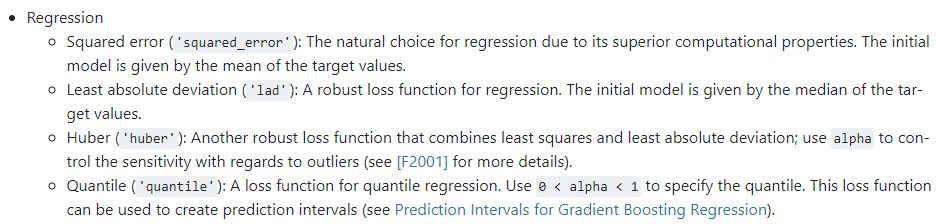

In [4]:
# define dataset
X, y = get_dataset()
X_test, y_test = get_datatest()

model = GradientBoostingRegressor(loss ='squared_error', learning_rate = 0.1, n_estimators=100)
model.fit(X, y)

GradientBoostingRegressor()

## Proses prediksi menggunakan model hasil training

In [5]:
yhat = model.predict(X_test)
yhat

array([10581.91912984, 13662.56968931, 15271.71290807, 16158.5579828 ,
       17341.04722252, 17742.07256406, 12403.98095265, 16980.97711735,
        9621.08616794, 16874.40273412,  9781.09468385, 11143.84766983,
       11917.82454674, 18135.90151193, 15945.91424094, 13532.98352057,
       11060.27354533,  9975.26572428, 14765.05006379,  8403.99785494,
       14985.18697406, 16885.82029225, 17450.27251066, 11036.27934588,
       15883.59457638, 16505.2791686 , 18247.93472415, 21076.32498488,
       19043.89412016, 19402.54855956, 16461.07286114,  9470.69102713,
       12682.56497341, 16439.98790729, 13926.96242469, 17119.47274723,
       14586.73175169, 13574.02004509, 18660.10174192, 11460.55051431,
       17832.31949349, 19878.23070454, 19806.98396739, 16097.99462927,
       16107.20789478, 16442.7358317 ,  9549.94925708, 16260.40235164,
       16260.40235164, 21552.00712986])

## Evaluasi keakuratan hasil regresi
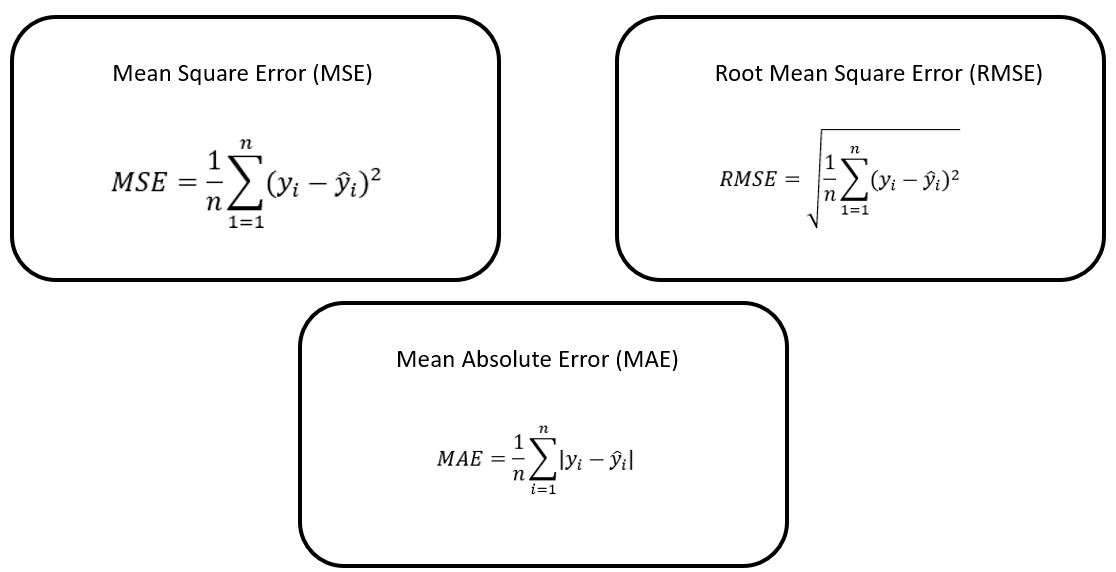

In [6]:
# Hasil MAE
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = mean_squared_error(y_test, yhat, squared= False)

print("========= Hasil Evaluasi =========")
print('Hasil MAE: %.2f MAE' % (mae))
print('Hasil MSE: %.2f MSE' % (mse))
print('Hasil RMSE: %.2f RMSE' % (rmse))

========= Hasil Evaluasi =========
Hasil MAE: 2178.61 MAE
Hasil MSE: 7648481.55 MSE
Hasil RMSE: 2765.59 RMSE


## Komparasi data dan hasil prediksi regresi dalam bentuk grafik

<AxesSubplot:>

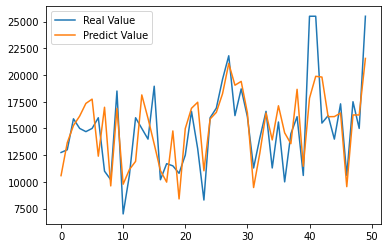

In [7]:
compare = pd.DataFrame(list(zip(y_test, yhat)), columns =['Real Value', 'Predict Value'])
compare.plot()